#### Import modules 

In [109]:
import os 
import tarfile
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy.stats import expon, reciprocal, randint
from sklearn.ensemble import RandomForestRegressor

# Prepare Data for ML

#### Load Data

In [6]:
# Function to download housing data from specified url into specified path
def fetch_housing_data(data_url, data_path):
    """Fetch housing tar zipped data file from specific URL into specific data path as CSV file"""
    os.makedirs(data_path, exist_ok=True)
    housing_tgz_path = os.path.join(data_path, "housing.tgz")
    urllib.request.urlretrieve(data_url, housing_tgz_path)
    with tarfile.open(housing_tgz_path) as housing_tgz:
        housing_tgz.extractall(data_path)
    return os.path.join(data_path, "housing.csv")

In [7]:
# Define variables for data_url and data_path
DATA_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
DATA_PATH = os.path.join("datasets", "housing")

# Load data
housing_data_csv = fetch_housing_data(DATA_URL, DATA_PATH)
housing_df = pd.read_csv(housing_data_csv)

#### Explore Data

In [8]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


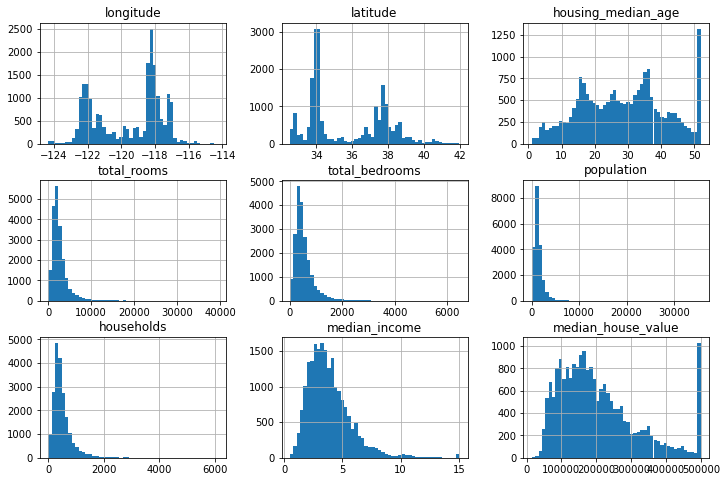

In [13]:
housing_df.hist(bins=50, figsize=(12, 8))
plt.show()

In [14]:
housing_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [15]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Prepare for Strata Distribution

<AxesSubplot:>

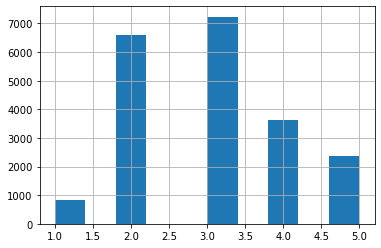

In [17]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing_df["income_cat"].hist()

#### Split train and test data (Stratified Split)

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_df = housing_df.loc[train_index]
    strat_test_df = housing_df.loc[test_index]

In [19]:
# Check the stratified split and overall data distribution by income_cat
def compute_proportions(dataset):
    return dataset["income_cat"].value_counts() / len(dataset)

overall_df = pd.DataFrame({
    "Overall": compute_proportions(housing_df),
    "Training": compute_proportions(strat_train_df),
    "Test": compute_proportions(strat_test_df),
})

overall_df

,Overall,Training,Test
3,0.350581,0.350594,0.350533
2,0.318847,0.318859,0.318798
4,0.176308,0.176296,0.176357
5,0.114438,0.114402,0.114583
1,0.039826,0.039850,0.039729


In [21]:
strat_train_df.size, strat_test_df.size

(181632, 45408)

In [22]:
# Remove income_cat
for dataset_ in (strat_train_df, strat_test_df):
    dataset_.drop("income_cat", axis=1, inplace=True)

In [24]:
strat_train_df.columns, strat_test_df.columns

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'))

#### Discover and Visualize Data

In [27]:
# Let's create a copy of training data for ad-hoc discovery and visualization
strat_train_df_copy = strat_train_df.copy()

In [28]:
strat_train_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [29]:
strat_train_df_copy.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


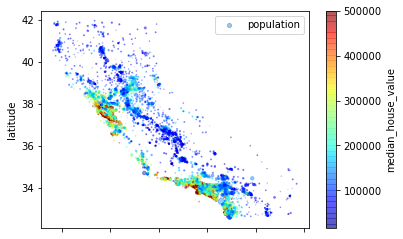

In [36]:
strat_train_df_copy.plot(kind='scatter', x='longitude', y='latitude', 
                        alpha=0.4, s=strat_train_df_copy['population']/1000, 
                        label='population', c='median_house_value', cmap='jet')
plt.show()

In [37]:
corr_matrix = strat_train_df_copy.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

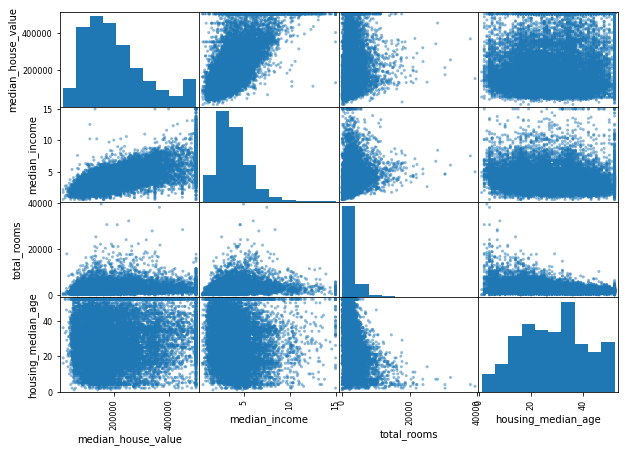

In [40]:
from pandas.plotting import scatter_matrix

attributes_of_interest = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(strat_train_df_copy[attributes_of_interest], figsize=(10, 7))
plt.show()

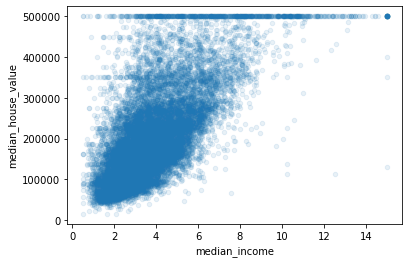

In [43]:
strat_train_df_copy.plot(kind='scatter', x='median_income', y='median_house_value',alpha=0.1)
plt.show()

In [44]:
# Let's examine some interesting attributes
strat_train_df_copy['rooms_per_household'] = strat_train_df_copy['total_rooms'] / strat_train_df_copy['households']
strat_train_df_copy['population_per_household'] = strat_train_df_copy['population'] / strat_train_df_copy['households']
strat_train_df_copy['bedrooms_per_room'] = strat_train_df_copy['total_bedrooms'] / strat_train_df_copy['total_rooms']

In [45]:
corr_matrix = strat_train_df_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#### Separate labels and predictors

In [57]:
housing_train_features = strat_train_df.copy()
housing_train_labels = housing_train_features.pop("median_house_value")

In [47]:
housing_train_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [48]:
housing_train_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

#### Separate numeric and categorical features

In [58]:
housing_train_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [59]:
housing_train_num_features = housing_train_features.drop('ocean_proximity', axis=1)

In [60]:
housing_train_num_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [61]:
housing_train_cat_features = housing_train_features[["ocean_proximity"]]

In [62]:
housing_train_cat_features.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


### Transformation pipeline

#### Custom Transformer for Adding Attributes

In [72]:
# Custom Transformer for Adding Attributes
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

#### Prepare numeric feature with numeric pipeline

In [73]:
# Create numeric pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scalar', StandardScaler())
])

#### Create Consolidated Pipeline

In [74]:
# Create consolidated pipeline

num_attribs = list(housing_train_num_features)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_train_prepared = full_pipeline.fit_transform(housing_train_features)

In [75]:
housing_train_prepared[:2]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

# ML Modeling

In [83]:
# Fit SVM Regression with kernel="linear" and C=1.0
svm_reg = SVR(C=5.0, kernel="linear")
svm_reg.fit(housing_train_prepared, housing_train_labels)

SVR(C=5.0, kernel='linear')

In [84]:
# Evaluate svm_reg model on training data set
svm_reg_predictions = svm_reg.predict(housing_train_prepared)
svm_reg_mse = mean_squared_error(housing_train_labels, svm_reg_predictions)
svm_reg_rmse = np.sqrt(svm_reg_mse)
svm_reg_rmse

91590.06955517201

In [87]:
# Fit SVM Regression with kernel="rbf" and C=1.0
svm_rbf_reg = SVR(C=5.0, kernel="rbf", gamma="auto")
svm_rbf_reg.fit(housing_train_prepared, housing_train_labels)

SVR(C=5.0, gamma='auto')

In [88]:
# Evaluate svm_reg model on training data set
svm_rbf_reg_predictions = svm_rbf_reg.predict(housing_train_prepared)
svm_rbf_reg_mse = mean_squared_error(housing_train_labels, svm_rbf_reg_predictions)
svm_rbf_reg_rmse = np.sqrt(svm_rbf_reg_mse)
svm_rbf_reg_rmse

117161.93455679461

# Fine-Tune Model

#### Grid Search

In [90]:
param_grid = [
    {'kernel': ['linear'], 'C': [1., 5., 10., 50., 100., 200., 500., 1000.0]},
    {'kernel': ['rbf'], 'C': [1., 5., 10., 50., 100., 200., 500., 1000.0],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_train_prepared, housing_train_labels)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ...............................C=1.0, kernel=linear; total time=  10.0s
[CV] END ...............................C=1.0, kernel=linear; total time=   9.8s
[CV] END ...............................C=1.0, kernel=linear; total time=   9.8s
[CV] END ...............................C=1.0, kernel=linear; total time=   9.7s
[CV] END ...............................C=1.0, kernel=linear; total time=   9.4s
[CV] END ...............................C=5.0, kernel=linear; total time=   8.9s
[CV] END ...............................C=5.0, kernel=linear; total time=  10.3s
[CV] END ...............................C=5.0, kernel=linear; total time=  10.6s
[CV] END ...............................C=5.0, kernel=linear; total time=   8.8s
[CV] END ...............................C=5.0, kernel=linear; total time=   7.2s
[CV] END ..............................C=10.0, kernel=linear; total time=   7.7s
[CV] END ..............................C=10.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1.0, 5.0, 10.0, 50.0, 100.0, 200.0, 500.0,
                                1000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 5.0, 10.0, 50.0, 100.0, 200.0, 500.0,
                                1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [91]:
# best score
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70445.38352171674

In [92]:
# best param
grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}

#### Randomized Search

In [95]:
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_train_prepared, housing_train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.7s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.3s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   7.4s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  17.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  17.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.1s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  15.5s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb301db7c0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb303514f0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [96]:
# best score
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084124

In [97]:
# best params
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [100]:
# Explore the expon and reciprocal
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
samples

array([0.46926809, 3.01012143, 1.31674569, ..., 2.93196746, 0.50664768,
       0.24480191])

In [102]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
samples

array([   629.78232959, 127024.42021281,  16943.60283764, ...,
       122422.61607663,    778.00424273,    147.77181645])

#### Transformer to select most important attributes

In [132]:
def indices_of_top_k(feature_importances, k):
        return np.sort(np.argpartition(np.array(feature_importances), -k)[-k:])
        
# Custom Transformer for selecting most important attributes
class TopFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k 

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self

    def transform(self, X):
        return X[:, self.feature_indices_]


# Note: this feature selector assumes that you have already computed the feature importances somehow 
# (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the 
# `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search 
# since the feature importances would have to be computed for every hyperparameter combination 
# (unless you implement some sort of cache).

##### Randomized Search with Random Forest Regressor

In [111]:
random_forest_reg_param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
forest_reg_rnd_search = RandomizedSearchCV(forest_reg, param_distributions=random_forest_reg_param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, return_train_score=True)
forest_reg_rnd_search.fit(housing_train_prepared, housing_train_labels)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb2f374bb0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdb303a1070>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [112]:
feature_importances = forest_reg_rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.24699052e-02, 6.38080322e-02, 4.27504395e-02, 1.65343807e-02,
       1.56100762e-02, 1.60929106e-02, 1.52149598e-02, 3.45178404e-01,
       5.74445360e-02, 1.08468449e-01, 7.05907498e-02, 8.77441303e-03,
       1.60563229e-01, 6.10403994e-05, 3.08961266e-03, 3.34886200e-03])

In [115]:
# Let's set k = 5
k = 5

# top k features
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [127]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)[:k]


[(0.3451784043801197, 'median_income'),
 (0.1605632289158767, 'INLAND'),
 (0.10846844860879654, 'population_per_household'),
 (0.07246990515559049, 'longitude'),
 (0.07059074984842853, 'bedrooms_per_room')]

##### Combined pipeline

In [133]:
# Let's make combined pipeline

preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_train_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing_train_features)

In [134]:
# Look at first three instances of prepared data with top k features
housing_train_prepared_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

In [136]:
# Let's validate the same with our earlier prepared training data with top_k_feature_indices
housing_train_prepared[0:3, top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

#### Single Pipeline for full data preparation and final prediction

In [138]:
# Let's create the pipeline
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [139]:
prepare_select_and_predict_pipeline.fit(housing_train_features, housing_train_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scalar',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

In [140]:
# Let's try the full pipeline on few instances
some_data = housing_train_features.iloc[:4]
some_labels = housing_train_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [185384.13066633 341000.56131536 172531.39955815  56040.55006166]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]
